```
notes:

- in sampling, we initialize z to be all ones. maybe we should do all zeros?

  actually i dont think it matters, the overwhelming quantity of data points makes the posterior disregard completely such hyperparameters and initializations.

- amazingly, by adding noise to the data the algorithm works better, but still the masking vectors are all 1. 
  how can we mke the algorithm more prone to setting some variables to zero instead of just sampling near zero from a gaussian?
```

In this notebook we will try to explore the `PySINDy` package architecture, in order to easily implement our bayesian version of this algorithm with a sparsity inducing prior.

We will implement a "custom" `optimizer` module, that will implement a Maximum A Posteriori (_MAP_) algorithm over the distribution derived from data and a (possibly sparsity-inducing) prior distribution.
The main difference is that this object will retain information over the whole probability distribution for the coefficients $\boldsymbol{\xi}$ and not just the best estimates, so that we can evaluate uncertainties over such parameters.

The goal of this algorithm is to compute

$$
P(\boldsymbol{\xi}|\boldsymbol{\dot{u}},\boldsymbol{\Theta}) = P(\boldsymbol{\dot{u}}|\boldsymbol{\xi},\boldsymbol{\Theta})P(\boldsymbol{\xi})
$$

Under the assumption that the likelihood of observing $\boldsymbol{\dot{u}}$ given a certain coefficients vector $\boldsymbol{\xi}$ is a gaussian with mean given by the linear relation:

$$
P(\boldsymbol{\dot{u}}|\boldsymbol{\xi},\boldsymbol{\Theta}) \sim \mathcal{N}(\boldsymbol{\Theta}^T\boldsymbol{\xi},\sigma^2)
$$


And $P(\boldsymbol{\xi})$ will be a sparsity inducing prior, so that the original goal of finding the smallest amount of explanatory terms possible is somewhat obtained.

### Spike and Slab regression

The spike and slab regression is considered to be the golden standard of sparsity inducing priors. The main idea behind it is to build prior that's a "mixture" of some smooth other "slab" prior (such as some ridge regression gaussian pit) and a delta function (the spike), centered at some point $v$; a latent random variable $Z \sim Ber(\theta_i)$ decides which prior to use:

$$
P(\xi_i | z_i) = 0 \sim \delta(\xi_i-v) \\
P(\xi_i | z_i) = 1 \sim P_{slab}(\xi_i) 
$$

So that the prior is the slab function with probability $\theta_i$ or collapses at $v$ with probability $1-\theta_i$. Setting $v=0$ corresponds to the sparsity assumption. If we marginalize over $z_i$:

$$
P(\xi_i) = \sum_{z_i=0}^1 P(\xi_i|z_i)P(z_i) = \theta_i P_{slab}(\xi_i) + (1-\theta_i)\delta(\xi_i)
$$

If we denote with $\circ$ the Hadamard product (element-wise product), we can express the likelihood of the data given a certain "masking vector" $\boldsymbol{z}$ and a coefficients vector $\boldsymbol{\xi}$ as

$$
P(\boldsymbol{\dot{u}}|\boldsymbol{\xi},\boldsymbol{z},\boldsymbol{\Theta},\sigma^2) \sim \mathcal{N}(<\boldsymbol{z}\circ \boldsymbol{\xi},\Theta>,\sigma^2)
$$

And thus, if we simply denote the data as $\mathcal{D}$, we have the posterior

$$
P(\boldsymbol{z},\boldsymbol{\xi}|\mathcal{D}) = \frac{1}{P(\mathcal{D})} P(\boldsymbol{z}) P_{slab}(\boldsymbol{\xi})\prod_{\mathcal{D}}P(\boldsymbol{\dot{u}}|\boldsymbol{\xi},\boldsymbol{z},\boldsymbol{\Theta},\sigma^2)
$$

The evidence would need to be computed by integrating over all (infinitely many) possible values of $\boldsymbol{\xi}$ and the all the possible ($2^N$) combinations for $\boldsymbol{z}$; it is clear that an analytical derivation of this posterior distribution is infeasible and a sampling approach will need to be deployed.



#### The `BaseOptimizer` class

This is the wrapper class for each optimizer algorithm that the package provides; we will build a optimizer module as a subclass of this wrapper. <a href=https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/base.html#BaseOptimizer>Source code</a> is available on the documentation.



In [1]:
from pysindy.optimizers import BaseOptimizer
import numpy as np
from sklearn.utils.validation import check_X_y
from sklearn.linear_model._base import _preprocess_data
from scipy.stats import beta,gamma,multivariate_normal,binom,mode
from alive_progress import alive_bar # package to print the pretty progress bar. can be installed with pip install alive-progress



def _rescale_data(X, y, sample_weight):
    """Rescale data so as to support sample_weight"""
    n_samples = X.shape[0]
    sample_weight = np.asarray(sample_weight)
    if sample_weight.ndim == 0:
        sample_weight = np.full(n_samples, sample_weight, dtype=sample_weight.dtype)
    sample_weight = np.sqrt(sample_weight)
    sw_matrix = sparse.dia_matrix((sample_weight, 0), shape=(n_samples, n_samples))
    X = safe_sparse_dot(sw_matrix, X)
    y = safe_sparse_dot(sw_matrix, y)
    return X, y


class SpikeSlabRegression (BaseOptimizer):
    """
    Bayesian Regression with a Spike and Slab type prior Optimizer.
    
    Computes the most likely combination of the coefficient vector
    and the masking vector using Bayesian inference to compute the 
    posterior distribution.

    Parameters
    ----------
    fit_intercept : boolean, optional (default False)
        Whether to calculate the intercept for this model. If set to false, no
        intercept will be used in calculations.

    normalize_columns : boolean, optional (default False)
        Normalize the columns of x (the SINDy library terms) before regression
        by dividing by the L2-norm. Note that the 'normalize' option in sklearn
        is deprecated in sklearn versions >= 1.0 and will be removed.

    copy_X : boolean, optional (default True)
        If True, X will be copied; else, it may be overwritten.
    

    max_iter : int, optional (default 5000)
        Maximum iterations of the optimization algorithm, i.e. the length of the Gibbs sampling chain.

    burn_in : int, optional (default 1500)
        Number of samples from the sampling chain to discard.
    
    verbose : boolean, optional (default False)
        enables verbose

    Attributes
    ----------

    coef_ : array, shape (n_features,) or (n_targets,n_features)
        Coefficients vector.

    ind_ : array, shape (n_features,) or (n_targets,n_features)
        Vector of BOOL values indicating whether or not a feature is considered relevant in the sparse representation.

    samples : list of length (n_targets) 
        Dictionaries containing np.arrays of the samples generated by the Gibbs sampling algorithm.

        
    """

    def __init__(
        self, 
        max_iter=5000, 
        burn_in=1500,
        normalize_columns=False, 
        fit_intercept=False, 
        initial_guess=None, 
        copy_X=True,
        tol=1e-5, # apparently needed for compatibility?
        alpha=None, # idk
        verbose=False
        ):

        # super() calls a temporary version of the parent class
        # this way we pass the init parameters to the class itself via inheritance
        # without having to rewrite everything
        super().__init__(max_iter, normalize_columns, fit_intercept, initial_guess, copy_X)

        self.tol=tol
        self.alpha=alpha
        self.burn_in = burn_in
        if self.max_iter <= 0:
            raise ValueError("Max iteration must be > 0")
        self.verbose=verbose

    # WE WILL OVERRIDE THE FIT METHOD FROM BaseEstimator SINCE WE WANT DIFFERENT .ind_ attributes

    def fit(self, x_, y, sample_weight=None, **reduce_kws):
        """
        Fit the model.

        Parameters
        ----------
        x_ : array-like, shape (n_samples, n_features)
            Training data

        y : array-like, shape (n_samples,) or (n_samples, n_targets)
            Target values

        sample_weight : float or numpy array of shape (n_samples,), optional
            Individual weights for each sample

        reduce_kws : dict
            Optional keyword arguments to pass to the _reduce method
            (implemented by subclasses)

        Returns
        -------
        self : returns an instance of self
        """

        # ----------- rescaling part
        x_, y = check_X_y(x_, y, accept_sparse=[], y_numeric=True, multi_output=True)

        x, y, X_offset, y_offset, X_scale = _preprocess_data(
            x_,
            y,
            fit_intercept=self.fit_intercept,
            copy=self.copy_X,
            sample_weight=sample_weight,
        )

        if sample_weight is not None:
            x, y = _rescale_data(x, y, sample_weight)

        self.iters = 0


        # ------------ preparing dimensions, if there is only one target (only one time derivative) then we set it (-1,1) shape
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        coef_shape = (y.shape[1], x.shape[1])
        self.ind_ = np.ones(coef_shape, dtype=bool)

        # ----------- normalization
        self.Theta_ = x # saving original theta
        x_normed = np.copy(x)
        if self.normalize_columns:
            reg = 1 / np.linalg.norm(x, 2, axis=0)
            x_normed = x * reg

        # ---------------------------------------------DO WE NEED THIS? NOT REALLY
        # ----------- initial guess via ols
        # if self.initial_guess is None:
        #     self.coef_ = np.linalg.lstsq(x_normed, y, rcond=None)[0].T
        # else:
        #     if not self.initial_guess.shape == coef_shape:
        #         raise ValueError(
        #             "initial_guess shape is incompatible with training data. "
        #             f"Expected: {coef_shape}. Received: {self.initial_guess.shape}."
        #         )
        #     self.coef_ = self.initial_guess


        # ---------------???
        # self.history_ = [self.coef_]



        # WHERE THE MAGIC HAPPENS

        self._reduce(x_normed, y, **reduce_kws)
        #self.ind_ = np.abs(self.coef_) > 1e-14 # WE WILL SET THIS IN THE REDUCE METHOD, its gonna be the most probable z vector

        # Rescale coefficients to original units
        if self.normalize_columns:
            self.coef_ = np.multiply(reg, self.coef_)
            if hasattr(self, "coef_full_"):
                self.coef_full_ = np.multiply(reg, self.coef_full_)
            for i in range(np.shape(self.history_)[0]):
                self.history_[i] = np.multiply(reg, self.history_[i])

        self._set_intercept(X_offset, y_offset, X_scale)
        return self
        

    def sampling(self,y,X,a1=0.01,a2=0.01,theta=0.5,a=1.,b=10.,s=5.):

        n_samples = X.shape[0]
        n_features = X.shape[1]

        # dictionary of empty arrays to store different samples
        res = {
            "beta" : np.empty((self.max_iter,n_features)),
            "z" : np.empty((self.max_iter,n_features)),
            "sigma2" : np.empty(self.max_iter),
            "tau2" : np.empty(self.max_iter),
            "theta" : np.empty(self.max_iter)
        }

        # initialize the masking as ones
        # OR ZEROS????
        res["z"][0] = np.zeros(n_features)
        # initialize the beta as least square regression
        res["beta"][0] = np.linalg.lstsq(X,y,rcond=None)[0]
        # initialize the sigma as the variance of the residuals
        res["sigma2"][0] = np.var(y - X @ res["beta"][0])
        # initialize the tau2 as one and the theta as 0.5
        res["tau2"][0] = 1.
        res["theta"][0] = 0.5

        # compute only once
        XtX = X.T @ X
        Xty = X.T @ y

        # ----------------- BEGIN SAMPLING
        with alive_bar(self.max_iter-1,force_tty=True) as bar:

            for i in range(1,self.max_iter):


                # lets retrieve the previous values for easier coding
                z_prev = res["z"][i-1]
                beta_prev = res["beta"][i-1]
                sigma2_prev = res["sigma2"][i-1]
                tau2_prev = res["tau2"][i-1]
                theta_prev = res["theta"][i-1]

                # ------------------ LETS GO WITH THE CONDITIONALS

                # sample theta from a Beta distribution
                theta_new = beta.rvs(a + np.sum(z_prev),b+np.sum(1-z_prev))

                # sample sigma2 from an inverse gamma
                err = y - X @ beta_prev
                scale = 1./(a2 + (err.T @ err)/2)
                sigma2_new = 1./gamma.rvs(a1+n_samples/2,scale=scale)

                # sample tau2 from an inverse gamma
                scale = 1./((s**2)/2 + (beta_prev.T @ beta_prev)/(2*sigma2_new))
                tau2_new = 1./gamma.rvs(0.5+0.5*np.sum(z_prev),scale=scale)

                # sample new beta from a multivariate gaussian
                covariance = np.linalg.inv(XtX/sigma2_new + np.eye(n_features)/(sigma2_new*tau2_new))
                mean = covariance @ Xty /sigma2_new # is this right?
                beta_new = multivariate_normal.rvs(mean = mean,cov=covariance)

                # now we sample the zjs
                # in random order
                for j in np.random.permutation(n_features):
                    
                    # grab the current vector
                    z0 = z_prev
                    # set j to zero
                    z0[j] = 0.
                    # get the beta_{-j}
                    bz0 = beta_new * z0

                    # compute the u variables (one for each sample)
                    xj = X[:,j] # the jth feature of each sample
                    u = y - X @ bz0 
                    cond_var = np.sum(xj**2) + 1./tau2_new

                    # compute the chance parameter:
                    # the probability of extracting zj = 0 is prop to (1-theta)
                    # while of extracting zj=1 is (.....) mess 
                    # computing the logarithm of these (l0 and l1) means that the probability of extracting zj=1 is
                    # xi = exp(l1)/(exp(l1)+exp(l0))
                    # we can also write this as
                    # xi = 1/(1+ exp(l0-l1))
                    # this way we can check if exp(l0-l1) overflows and just call it xi = 0

                    l0 = np.log(1-theta_new)
                    l1 = np.log(theta_new) \
                        - 0.5 * np.log(tau2_new*sigma2_new) \
                        + (np.sum(xj*u)**2)/(2*sigma2_new*cond_var) \
                        + 0.5*np.log(sigma2_new/cond_var)

                    el0_l1 = np.exp(l0-l1)
                    if np.isinf(el0_l1):
                        xi = 0
                    else:
                        xi = 1/(1+el0_l1)
                    
                    # extract the zj
                    z_prev[j]=binom.rvs(1,xi)

                # once we extracted all zj, store them:
                z_new = z_prev

                # update everything

                res["z"][i] = z_new
                # res["beta"][i] = beta_new
                res["beta"][i] = beta_new*z_new
                res["sigma2"][i] = sigma2_new
                res["tau2"][i] = tau2_new
                res["theta"][i] = theta_new

                if self.verbose:
                    bar()

            # ---------- END SAMPLING

        for k in res.keys():
            res[k] = res[k][self.burn_in:]
        
        return res 


    def _reduce(self,x,y,**sampling_kws):
        """
        Reduce method to actually perform the minimization.
        This method performs a Gibbs sampling of the joint probability distribution
        Under the spike and slab prior method, and will return the coefficients
        as the most probable one, given the most probable masking coefficient.
        """

        n_samples, n_features = x.shape
        # what if there are multiple targets? i.e. a 3d dynamical system?
        n_targets = y.shape[1]
        # then we need to perform the regression and find (n_targets) vector of coefficients.
        # so the coefficient will be
        coef = np.zeros((n_targets,n_features))
        ind = np.zeros((n_targets,n_features))
        self.samples = []

        for i in range(n_targets):

            if self.verbose: 
                print("Sampling for feature n# {}/{}...".format(i,n_targets-1))
            
            # KERNEL DENSITY ESTIMATE HERE MAYBE?
            # but for now only pick the mean

            # we can call y[i] because it's been reshaped to (-1,1) even if n_targets=1
            self.samples.append(self.sampling(y[:,i],x,**sampling_kws))
            coef[i] = np.mean(self.samples[i]['beta'],axis=0)
            ind[i] = mode(self.samples[i]['z']) != 0 # setting the .ind_ attribute as a boolean vector


        self.coef_ = coef

        self.ind_ = ind


    def summary(self):

        for target in range(len(self.samples)):
            
            print("------------------------")
            print("Target variable n# ",target)

            beta_mean = np.mean(self.samples[target]['beta'],axis=0)
            beta_std = np.std(self.samples[target]['beta'],axis=0)
            print("Marginalized Beta distribution mean:")
            print(beta_mean)
            print("Marginalized Beta distribution std:")
            print(beta_std)
            
            print("\n\n")

            z_mean = np.mean(self.samples[target]['z'],axis=0)
            z_std = np.std(self.samples[target]['z'],axis=0)
            print("Marginalized Z distribution mean:")
            print(z_mean)
            print("Marginalized Z distribution std:")
            print(z_std)

            print("\n\n")

            tau2_mean = np.mean(self.samples[target]['tau2'])
            tau2_std = np.std(self.samples[target]['tau2'])
            print("Marginalized Tau2 distribution mean:")
            print(tau2_mean)
            print("Marginalized Tau2 distribution std:")
            print(tau2_std)

            print("\n\n")

            sigma2_mean = np.mean(self.samples[target]['sigma2'])
            sigma2_std = np.std(self.samples[target]['sigma2'])
            print("Marginalized Sigma2 distribution mean:")
            print(sigma2_mean)
            print("Marginalized Sigma2 distribution std:")
            print(sigma2_std)

            print("\n\n")

            theta_mean = np.mean(self.samples[target]['theta'])
            theta_std = np.std(self.samples[target]['theta'])
            print("Marginalized Theta distribution mean:")
            print(theta_mean)
            print("Marginalized Theta distribution std:")
            print(theta_std)
            




    


In [2]:
import pysindy as ps

# load data
r_noisy = np.load("./data/lorenz_r_noisy.npy")
t = np.load("./data/lorenz_t.npy")

# r is shaped like (n_points,n_dimensions)
print("Data vector:")
print(r_noisy[:5])

# t is time axis
print("\n\nTime vector:")
print(t[:5])

feature_names = ['x','y','z'] # just a label for the features, instead of simply using x1,x2....

opt=SpikeSlabRegression(max_iter=5000,burn_in=1500,verbose=True)

model = ps.SINDy(feature_names=feature_names,optimizer=opt) 


Data vector:
[[1.         1.         1.        ]
 [1.01256821 1.2599461  0.98488969]
 [1.04883096 1.52405449 0.97311235]
 [1.10722704 1.79839899 0.96515735]
 [1.18690156 2.08866556 0.96173704]]


Time vector:
[0.       0.010001 0.020002 0.030003 0.040004]


In [3]:
# .fit method from pysindy class does not have a **kwargs!
model.fit(r_noisy,t=t) 

Sampling for feature n# 0/2...
|████████████████████████████████████████| 4999/4999 [100%] in 39.7s (125.88/s)                                         
Sampling for feature n# 1/2...
|████████████████████████████████████████| 4999/4999 [100%] in 53.4s (93.60/s)                                          
Sampling for feature n# 2/2...
|████████████████████████████████████████| 4999/4999 [100%] in 49.1s (101.84/s)                                         


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y', 'z'],
      optimizer=SpikeSlabRegression(verbose=True))

In [4]:
model.print() # some of the coefficients may not show up even if their .ind_ is True; this is because
              # the precision argument in .print() defaults to 3 decimal places and if they are all zeros
              # the term isnt printed


(x)' = 0.003 1 + -10.056 x + 10.040 y + 0.002 x z + -0.002 y z
(y)' = 0.029 1 + 27.799 x + -0.955 y + -0.003 z + -0.994 x z
(z)' = -0.292 1 + -0.012 x + 0.008 y + -2.586 z + 0.025 x^2 + 0.973 x y + 0.006 y^2 + -0.003 z^2


[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


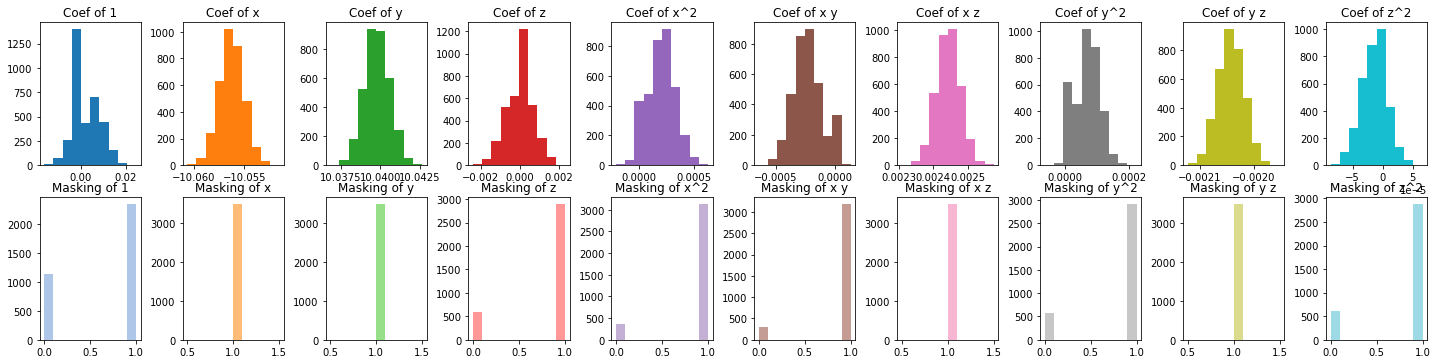

In [5]:
import matplotlib.pyplot as plt

# lets look at the x' equation
samp = model.optimizer.samples[0]
feat = model.get_feature_names()

fig, axs = plt.subplots(2,10,figsize=[20,5])
colors=plt.get_cmap('tab20')
fig.tight_layout()
for i in range(10):
    axs[0,i].hist(samp['beta'][:,i],color=colors.colors[2*i])
    axs[0,i].set_title("Coef of {}".format(feat[i]))
    axs[1,i].hist(samp['z'][:,i],color=colors.colors[2*i+1])
    axs[1,i].set_title("Masking of {}".format(feat[i]))


print(model.optimizer.ind_)

sigma2 mean:  0.004973026993137314
tau2 mean:  5237.827672379897
theta mean:  0.47452365684904624
sigma2*tau2 mean:  26.047858400146815


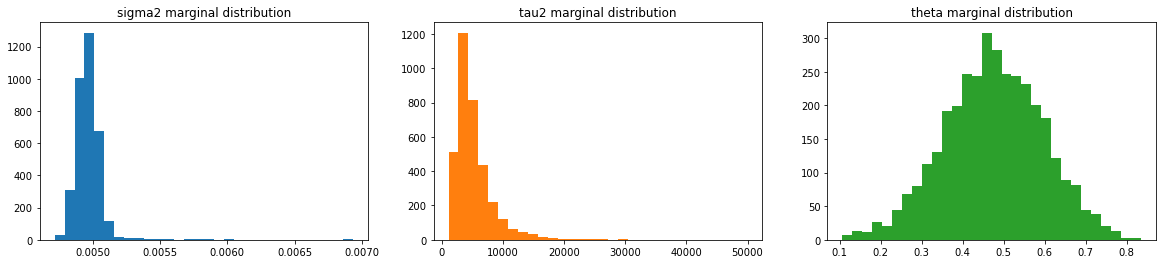

In [25]:
fig,axs = plt.subplots(1,3,figsize=[20,4])

print("sigma2 mean: ",np.mean(samp['sigma2']) )
print("tau2 mean: ",np.mean(samp['tau2']) )
print("theta mean: ",np.mean(samp['theta']) )

print("sigma2*tau2 mean: ",np.mean(samp['sigma2'])*np.mean(samp['tau2'])) # this is the variance of the slab prior for beta

nbins=30
axs[0].hist(samp['sigma2'],color='C0',bins=nbins)
axs[0].set_title("sigma2 marginal distribution")
axs[1].hist(samp['tau2'],color='C1',bins=nbins)
axs[1].set_title("tau2 marginal distribution")
axs[2].hist(samp['theta'],color='C2',bins=nbins)
axs[2].set_title("theta marginal distribution")
plt.show()